In [22]:
import pandas as pd
import numpy as np
import librosa

In [23]:
df = pd.read_csv('data.csv')

In [24]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [25]:
df = df.drop(['beats'], axis=1)

In [26]:
df.head()

,class_name,tempo,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues,103.359375,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues,95.703125,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues,151.999081,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues,184.570312,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues,161.499023,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


# Preprocesing

In [27]:
df['class_name'].unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [28]:
df['class_name'] = df['class_name'].astype('category')
df['class_label'] = df['class_name'].cat.codes

In [29]:
lookup_genre_name = dict(zip(df.class_label.unique(), df.class_name.unique()))   
lookup_genre_name

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [30]:
df['class_name'].unique()

[blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock]
Categories (10, object): [blues, classical, country, disco, ..., metal, pop, reggae, rock]

In [31]:
cols = list(df.columns)
cols.remove('label')
cols.remove('class_label')
cols.remove('class_name')
#df[cols]

# Data Splitting for Training and Testing

In [32]:
%matplotlib notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X = df.iloc[:,1:28]
y = df['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# Min-Max Normalization

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

# Feature importance using Random Forest

<IPython.core.display.Javascript object>


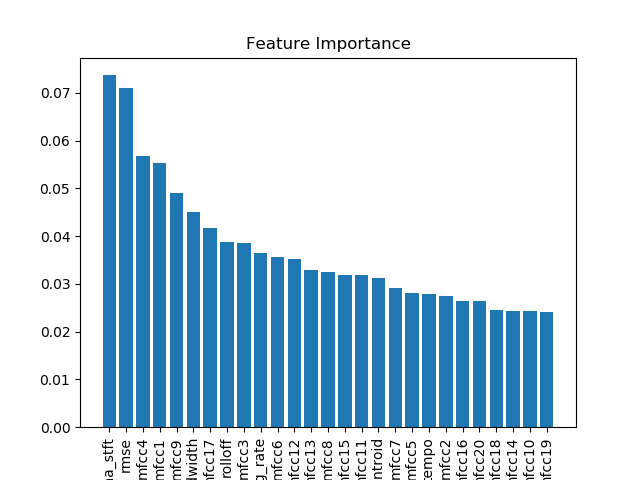

In [34]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib notebook
clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

# Feature importance using Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

# K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

In [ ]:
def getmetadata(filename):
    import librosa
    import numpy as np


    y, sr = librosa.load(filename)
    #fetching tempo

    onset_env = librosa.onset.onset_strength(y, sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)

    #fetching beats

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,sr=sr)

    #chroma_stft

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

    #rmse

    rmse = librosa.feature.rms(y=y)

    #fetching spectral centroid

    spec_centroid = librosa.feature.spectral_centroid(y, sr=sr)[0]

    #spectral bandwidth

    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    #fetching spectral rolloff

    spec_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]

    #zero crossing rate

    zero_crossing = librosa.feature.zero_crossing_rate(y)

    #mfcc

    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    #metadata dictionary

    metadata_dict = {'tempo':tempo,'chroma_stft':np.mean(chroma_stft),'rmse':np.mean(rmse),
                     'spectral_centroid':np.mean(spec_centroid),'spectral_bandwidth':np.mean(spec_bw), 
                     'rolloff':np.mean(spec_rolloff), 'zero_crossing_rates':np.mean(zero_crossing)}

    for i in range(1,21):
        metadata_dict.update({'mfcc'+str(i):np.mean(mfcc[i-1])})

    return list(metadata_dict.values())



# Fetching File Metadata For Prediction

In [ ]:

a = getmetadata("Exquisite Afternoon Raag Bhimpalasi _ Kaushiki Chakraborty _ Patiala Khayal _ Music of India (mp3cut.net).wav")


# Predicting using KNN

In [ ]:
d1 =np.array(a)
data1 = scaler.transform([d1])
genre_prediction = knn.predict(data1)

print(lookup_genre_name[genre_prediction[0]])

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C=10).fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)


# Predicting Using SVM

In [ ]:
d1 =np.array(a)
data1 = scaler.transform([d1])
genre_prediction = clf.predict(data1)
print(lookup_genre_name[genre_prediction[0]])

In [ ]:
import pickle
pick1 = {
    'norma':scaler,
    'svmp':knn,
    'lgn':lookup_genre_name
}
pickle.dump( pick1, open( 'models' + ".p", "wb" ) )